# Data Analysis Take Home Interview

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [212]:
import json
import pandas as pd 
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from collections import OrderedDict
from mixed_naive_bayes import MixedNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

### 1b. Load the data

In [213]:
df = pd.read_json('logins.json', typ='frame')

### 1c.  Explore the data

Confirm that the data is appropriate for a time series style analysis. 

In [214]:
type(df)

pandas.core.frame.DataFrame

In [215]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Check out the columns feature of the data. How many columns are there?

In [216]:
df.columns, len(df.columns)

(Index(['login_time'], dtype='object'), 1)

Let's check out the data types of our columns.

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


Are there any null values?

In [218]:
print(df.isnull().sum())

login_time    0
dtype: int64


In [219]:
df.index

RangeIndex(start=0, stop=93142, step=1)

## 2. Cleaning, transforming and visualizing

### 2a. Create a datetime index and drop the extra column

In [220]:
df.login_time = pd.to_datetime(df['login_time'])

In [221]:
df.index = df.login_time

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


### 2a. Resample in 15 minute intervals (groupby)

In [223]:
# data re-sampled based on 15 minute intervals
resampled = pd.DataFrame(df.resample('15T').count())

### 2b. Nomenclature

Rename the second column to represent that it is the numnber of logins per 15 minute period. 

In [224]:
resampled.rename(columns = {'login_time' : 'NumOfLogins'}, inplace=True)

In [225]:
resampled.head()

,NumOfLogins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Let's check to see if the data is consistent. Months are different lengths, if we count the number of records per month we can get a rough idea of if the data is complete. 
We can also save the subsets of data in month groupings to make it easier to plot later. 

In [226]:
# Add a new column which containes the month name
resampled['month'] = [d.strftime('%b') for d in resampled.index]

# create an array of months, and a dictionary of dataframes
months = resampled['month'].unique()
d = {m: pd.DataFrame() for m in months}

# iterate over months array to generate length of each, and populated each dataframe in d dict
for m, i in zip(months, d):
    print(m, len(resampled[resampled['month'] == m]))
    d[m] = resampled[resampled['month'] == m]

Jan 2896
Feb 2688
Mar 2976
Apr 1228


April's data is clearly incomplete. February is a short month, so that length looks about right. We can keep April's data, but be aware that there is not data for every 15 minutes in the entire month. 

## 3. Exploratory Data Analysis

Do a quick plot, and check if this time series is a random walk. 

In [227]:
# Compute and print ADF p-value
result = adfuller(resampled['NumOfLogins'])
print("The p-value for the ADF test is ", result[1])

The p-value for the ADF test is  2.7323966542231624e-18


The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary. 

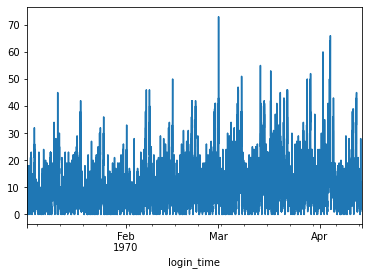

In [228]:
# quick plot
resampled['NumOfLogins'].plot()
plt.show()

There is clearly a seasonality to this data. It looks like there are weekly cycles, instead of monthly cycles. 
It looks like the end of April is missing. We can see by looking at the tail of the data that this is indeed the case; April data goes through 4-13-21 only. 

In [229]:
# Show where the end of the data is, in time
resampled.tail()

,NumOfLogins,month
login_time,,
1970-04-13 17:45:00,5,Apr
1970-04-13 18:00:00,5,Apr
1970-04-13 18:15:00,2,Apr
1970-04-13 18:30:00,7,Apr
1970-04-13 18:45:00,6,Apr


Create a plot of each month's data separately to see if the seasonality is consistent. 

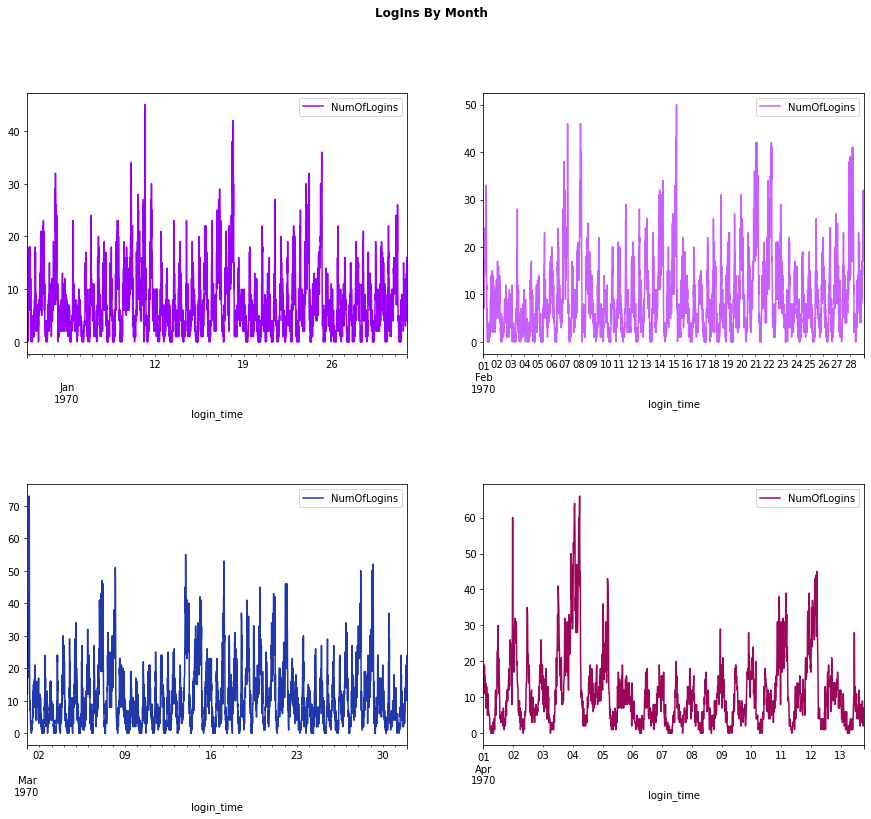

In [230]:
# Prep Colors -- Create random list of colors in the same length as the number of month we will plot

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(months), replace=False)


# define subplot grid

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("LogIns Every 15 Min", fontsize=18, y=0.95)



# Draw Plot
# Loop on the np array of months and the flattened list of axes
for m, ax, i in zip(months, axs.ravel(), mycolors):
    d[m].plot(ax=ax, color=i, label=m)

# Add Title
fig.suptitle('LogIns By Month', fontweight ="bold")

# Decoration
#plt.gca().set(xlim=(0, 31), ylim=(0, 70), ylabel='$LogIns$', xlabel='$Month$')

plt.show()

Over the four months, we see there is a weekly cycle and also a daily cycle. Let's plot just one week of March to show this pattern. 

<AxesSubplot:xlabel='login_time'>

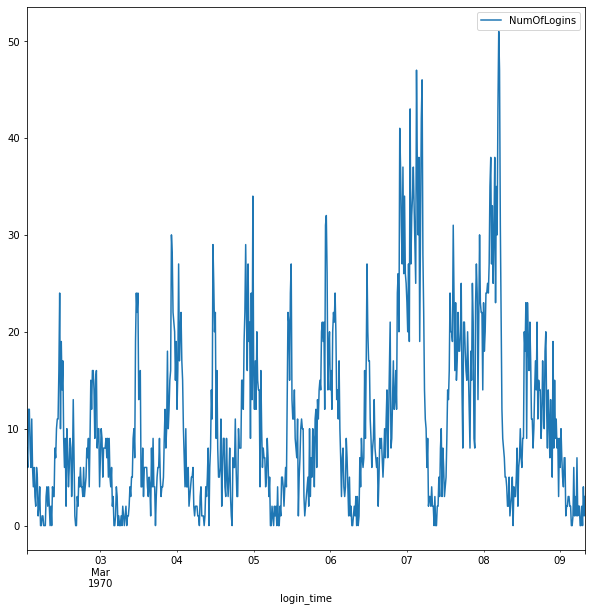

In [231]:
d['Mar'].iloc[100:800].plot(figsize=(10, 10))

March 3, 1970 is a Tuesday and the 6th is a Friday. Logins are higher on the weekend. 
Let's plot just the weekend, and see what time of day is the highest:

<AxesSubplot:xlabel='login_time'>

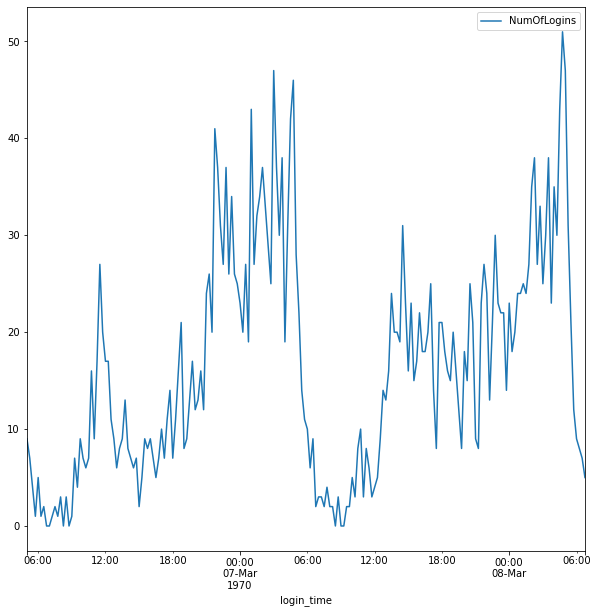

In [232]:
d['Mar'].iloc[500:700].plot(figsize=(10, 10))

Logins are the highest late at night and early in the morning on the weekends. 
This seems to be true for all months (making assumptions about incomplete April data). 

## 4. Experiment and Metrics

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.



1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

I would use directional toll crossings. The driver partners from Gotham should be crossing into Metropolis during the day, and the drivers from Metropolis should be driving into Gotham at night. 

The time series representing the toll crossing out of Gotham should have peaks at or before the period of high activity in Metropolis, and the time series representing the toll crossing out of Metropolis should have peaks at or before the period of high activity in Gotham. The opposite should also be true. 

2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

b) what statistical test(s) you will conduct to verify the significance of the
            observation

c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

We start by making the tolls reimbursable on one 24-hour period per week. We choose it to be a weekend when there is the most traffic, perhaps from midnight to midnight. We let all the driver partners know of this new reimbursable toll time, and suggest that they can improve their productivity by driving to the other city during lulls in their own city. 

We collect time stamps of driver partners crossing the tolls. We collect their home city, their direction of travel, and the time. We downsample the timestamps into 15 minute periods for data analysis. This collection is done before the experiment, and while the tolls are reimbursable. 

Once the time series are created, we can use the "control" (the time series data collected before the experiment began) and the test data to see what the likelihood is that the experimental time series could be forecasted by the control data. If the p-value is less than perhaps 0.05, we can reject the null hypothesis that patterns of travel were unaffected. 

If the experiment is successful, we may expand the experiment to other days. It may be helpful to find out how many routes the drivers are making in the opposite city, and provide that information to the operations team as a ratio of routes to tolls reimbursed. We need to let the operations team know that there is a margin of error in our forecasting and that predictions are more accurate closer to the experiment than further out in time, due to noise and drift. 


## 5. Predictive Modeling

### 5a) Problem Statement

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

### 5b) Load and clean

Load data and display the first 5 rows. 

In [233]:
ret = pd.read_json('ultimate_data_challenge.json', typ='frame')
ret.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [234]:
ret.info(), ret.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


(None,
 city                         0
 trips_in_first_30_days       0
 signup_date                  0
 avg_rating_of_driver      8122
 avg_surge                    0
 last_trip_date               0
 phone                      396
 surge_pct                    0
 ultimate_black_user          0
 weekday_pct                  0
 avg_dist                     0
 avg_rating_by_driver       201
 dtype: int64)

it looks like there are 50,000 records and some nulls, the most occuring in the avg_rating_of_driver and some also occuring in phone and avg_rating_by_driver. 
Phone number won't have any affect on retention since it's not descriptive in any way, so that column isn't important. 
However, the average rating of the drivers over all of a rider's trips seems like it may be quite important indeed. 

This data field is missing from almost 20% of records. 

We have the following choices: We could impute the data somehow, or we could remove those rows. 

I will drop the phone column, and then drop all rows containing an NaN. 
My reasoning for this is that I surmise rating is very important in the rentention equation. To impute 20% of an important data field with a value such as the mean or median may significantly the outcome. 

In [235]:
# drop the 'phone' columns
ret.drop(columns=['phone'], axis=1, inplace=True)

In [236]:
# drop all rows containing an Nan
ret.dropna(inplace=True)

In [237]:
# display remaining row count
ret.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41744 non-null  object 
 1   trips_in_first_30_days  41744 non-null  int64  
 2   signup_date             41744 non-null  object 
 3   avg_rating_of_driver    41744 non-null  float64
 4   avg_surge               41744 non-null  float64
 5   last_trip_date          41744 non-null  object 
 6   surge_pct               41744 non-null  float64
 7   ultimate_black_user     41744 non-null  bool   
 8   weekday_pct             41744 non-null  float64
 9   avg_dist                41744 non-null  float64
 10  avg_rating_by_driver    41744 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(3)
memory usage: 3.5+ MB


In [238]:
# describe data
ret.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000
mean,2.611393,4.601801,1.073697,8.884695,61.304437,5.465312,4.776648
std,4.060121,0.616079,0.198681,18.309042,34.799944,5.149810,0.404109
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,37.500000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.790000,5.000000
75%,3.000000,5.000000,1.070000,11.100000,100.000000,6.490000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,79.690000,5.000000


Let's fix some of the columns - 
change 'city' to a categorical column,
'signup_date' and 'last_trip_date' to datetime.

In [239]:
# change two columns to datetime
ret.signup_date = pd.to_datetime(ret['signup_date'])
ret.last_trip_date = pd.to_datetime(ret['last_trip_date'])

In [240]:
# check unique values in 'city'
ret.city.unique(), len(ret.city.unique())

(array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object), 3)

Let's use an encoder. 

In [241]:
# instantiate encoder. 
le = LabelEncoder()

In [242]:
ret['city_categorical'] = le.fit(ret['city']).transform(ret['city'])

In [243]:
ret['city_categorical'] = ret['city_categorical'].astype('category')
ret.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41744 non-null  object        
 1   trips_in_first_30_days  41744 non-null  int64         
 2   signup_date             41744 non-null  datetime64[ns]
 3   avg_rating_of_driver    41744 non-null  float64       
 4   avg_surge               41744 non-null  float64       
 5   last_trip_date          41744 non-null  datetime64[ns]
 6   surge_pct               41744 non-null  float64       
 7   ultimate_black_user     41744 non-null  bool          
 8   weekday_pct             41744 non-null  float64       
 9   avg_dist                41744 non-null  float64       
 10  avg_rating_by_driver    41744 non-null  float64       
 11  city_categorical        41744 non-null  category      
dtypes: bool(1), category(1), datetime64[ns](2), fl

Let's handle the dates. Datetime objects can't be used in machine learning, so we need to make some features out of the columns: signup_date and last_trip_date. 
One handy feature could be the elapsed number of days between signup_date and last_trip_date. 
Another feature could be their last trip was in the evening hours, or in the daytime. 
This whole project is an exercise, so I'm going to stop there. Let's add one of those features. 

In [244]:
ret['Day_Signup_to_Last'] = (ret['last_trip_date'] - ret['signup_date'])
ret['Day_Signup_to_Last'] = ret['Day_Signup_to_Last'].astype('timedelta64[D]')
ret['Day_Signup_to_Last'] = ret['Day_Signup_to_Last'].astype(int)

In [245]:
ret.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41744 non-null  object        
 1   trips_in_first_30_days  41744 non-null  int64         
 2   signup_date             41744 non-null  datetime64[ns]
 3   avg_rating_of_driver    41744 non-null  float64       
 4   avg_surge               41744 non-null  float64       
 5   last_trip_date          41744 non-null  datetime64[ns]
 6   surge_pct               41744 non-null  float64       
 7   ultimate_black_user     41744 non-null  bool          
 8   weekday_pct             41744 non-null  float64       
 9   avg_dist                41744 non-null  float64       
 10  avg_rating_by_driver    41744 non-null  float64       
 11  city_categorical        41744 non-null  category      
 12  Day_Signup_to_Last      41744 non-null  int32 

### 5c) Create "Retained" column

In [246]:
ret.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41744 non-null  object        
 1   trips_in_first_30_days  41744 non-null  int64         
 2   signup_date             41744 non-null  datetime64[ns]
 3   avg_rating_of_driver    41744 non-null  float64       
 4   avg_surge               41744 non-null  float64       
 5   last_trip_date          41744 non-null  datetime64[ns]
 6   surge_pct               41744 non-null  float64       
 7   ultimate_black_user     41744 non-null  bool          
 8   weekday_pct             41744 non-null  float64       
 9   avg_dist                41744 non-null  float64       
 10  avg_rating_by_driver    41744 non-null  float64       
 11  city_categorical        41744 non-null  category      
 12  Day_Signup_to_Last      41744 non-null  int32 

We need to figure out which of these users was "retained". The problem statement says that data was pulled in 2014, and users are considered retained if they completed a ride within the last 30 days. Let's look at the last trip date to ascertain when the data was pulled. 

In [247]:
# return information about the last_trip_date
ret['last_trip_date'].describe(datetime_is_numeric=True)

count                            41744
mean     2014-04-24 12:22:14.994250752
min                2014-01-01 00:00:00
25%                2014-02-24 00:00:00
50%                2014-05-16 00:00:00
75%                2014-06-20 00:00:00
max                2014-07-01 00:00:00
Name: last_trip_date, dtype: object

The latest trip date is 7/1/2014 so I will assume that the date was pulled on 7/1/2014 at 00:00:01. Any users completing rides within 30 days preceding that date will be "retained". "Retained" will be a 1 indicating true and 0 indicating false. 

In [248]:
# Create datetime comparison date
ret_date = datetime.datetime(2014,6,1,0,0,0)

In [249]:
# Create retained column using list comp
ret['retained'] = [1 if d > ret_date else 0 for d in ret['last_trip_date']]

In [250]:
# change to categorical
ret['retained'] = ret['retained'].astype('category')

### 5d) Exploratory data analysis

How many customers were retained after 6 months?

In [251]:
cr = {'True': len(ret[ret['retained'] == 1]), 
     'False': len(ret[ret['retained'] == 0])}
print(cr)

{'True': 16728, 'False': 25016}


In [252]:
print("The percentage of customers retained is about {:00.00%}".format(len(ret[ret['retained'] == 1])/len(ret)))

The percentage of customers retained is about 40%


We now know that about 40% of customers who signed up were retained 6 months later. 
Did it make a difference how many rides they took in the first month? 

In [253]:
# Create a dict of key:values for # of trips in first 30 days to is retained or not
list1 = ret.trips_in_first_30_days.unique().tolist()
list1.sort()
list2 = []
for i in range(len(list1)):
    list2.append((len(ret[(ret['trips_in_first_30_days'] == list1[i]) & (ret['retained'] == 1)]), 
                len(ret[(ret['trips_in_first_30_days'] == list1[i]) & (ret['retained'] == 0)])))

    
    
d = dict(zip(list1, list2))

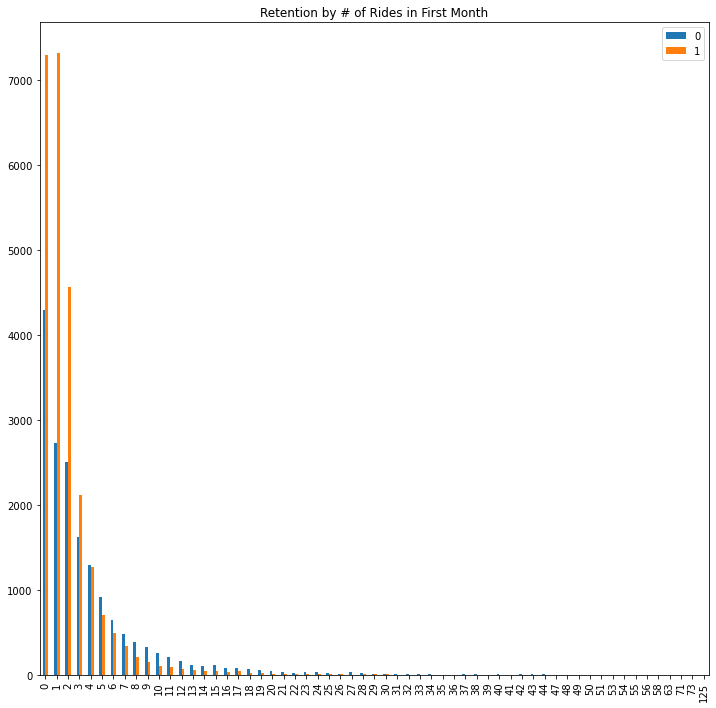

In [254]:
df = pd.DataFrame(d)
df = df.transpose()

df.plot(kind="bar", stacked=False, figsize=(12,12))
plt.title('Retention by # of Rides in First Month')
plt.legend({0: 'not retained', 1:'retained'})
plt.show()

It looks from this chart as though until rides in the first month exceeding 4, retention exceeded non-retention. However, as rides per first month increased, retention went down. Amazingly, one rider used the service 125x in the first month. I would guess his car broke down.

### 5e) Modeling and Prediction

Because we have both categorical and continuous data, I'm going to use a Mixed Naive Bayes model. 

From the documentation:
"This module implements Categorical (Multinoulli) and Gaussian naive Bayes algorithms (hence mixed naive Bayes). This means that we are not confined to the assumption that features (given their respective y's) follow the Gaussian distribution, but also the categorical distribution. Hence it is natural that the continuous data be attributed to the Gaussian and the categorical data (nominal or ordinal) be attributed the the categorical distribution."  -- https://pypi.org/project/mixed-naive-bayes/

In [255]:
# Split X and y, removing the city name category, datetime objects, and the boolean ultimate_black_user. 

X = ret.drop(columns=['city', 'retained', 'last_trip_date', 'signup_date', 'ultimate_black_user'])
y = ret.retained

In [256]:
# Check the location of the categorical column for assigment to the Multinoulli naive Bayes algorithm. 
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   trips_in_first_30_days  41744 non-null  int64   
 1   avg_rating_of_driver    41744 non-null  float64 
 2   avg_surge               41744 non-null  float64 
 3   surge_pct               41744 non-null  float64 
 4   weekday_pct             41744 non-null  float64 
 5   avg_dist                41744 non-null  float64 
 6   avg_rating_by_driver    41744 non-null  float64 
 7   city_categorical        41744 non-null  category
 8   Day_Signup_to_Last      41744 non-null  int32   
dtypes: category(1), float64(6), int32(1), int64(1)
memory usage: 2.7 MB


In [257]:
# implement train/test split from sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [258]:
# check shape of X
X_train.shape, X_test.shape

((29220, 9), (12524, 9))

In [259]:
# check shape of y
y_train.shape, y_test.shape

((29220,), (12524,))

In [260]:
# instantiate model, fit and predict
clf = MixedNB(categorical_features = [7])
clf.fit(X_train,y_train)
clf.predict(X_test)

[3]


array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

Naive Bayes is a generative classifier, so our output is always a strict classification, as opposed to logistic regression or some other discriminative classifier.

In [261]:
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(X_test), y_test))

0.9248642606196104


From a very first model, an accuracy of 92.5% retention prediction is pretty good! 

In [262]:
imps = permutation_importance(clf, X_test, y_test)
print(imps.importances_mean)

[0.00164484 0.00068668 0.004168   0.00542958 0.00038326 0.00191632
 0.00300224 0.00547748 0.37015331]


Naive Bayes does not use a coefficient method like some other models. Instead we can use Permutation, which assigns a value of affect on the metric Accuracy when a certain variable is shuffled. From this data it looks as though the most important feature is the number of days between first signup and the last ride. This makes sense, because it rules out users who used the serviec and didn't like it, or used it for a particular purpose (car broke down) and never used it again. 
Other important features are the surge_pct and the city. 

## 6. Conclusion

I chose to go with a mixed bayes algoritm, which combines a multinoulli and gaussian approach. 

Another option would have been to bin all of the continuous variables, and use a strict categorical approach like a SVM or a random forest model. 

Because I did not delve very deeply into creating features from the datetime variables, and because I completely disregarded the boolean Ultimate Black variable, I feel confident that it would be possible to create a more accurate model than the current, untuned model which has an accuracy of 92.5%. 
